# Diffusion Tutorial

Python notebook for loading a (modified, pretrained) U-Net neural network (plus the training code, for completeness, though you may not use it in practice). In this lab, you will implement the progressive denoising of a pure-noise image using the process seen in the lecture. You will be able to test a small U-Net trained on a large dataset of faces and a small dataset of 50 holiday pictures, as well as a bigger-sized U-Net trained on the LFW dataset.

## Donwloading datasets

In [1]:
%%capture
# please comment out once downloaded once to avoid re-downloading at each run !
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/unets.py
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/fullmodel_unetsmall_faces.pt
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/fullmodel_unetsmall_faces2.pt
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/fullmodel_unetsmall_photos.pt
# !wget https://perso.liris.cnrs.fr/nicolas.bonneel/diffusion/fullmodel_unet_faces.pt

## Importing libraries

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import time
from mpl_toolkits.axes_grid1 import ImageGrid
import unets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Generate an image

In [ ]:
def load(path, device):
    net = unets.UNet if path == "./fullmodel_unet_faces.pt" else unets.UNetSmall
    model = net(image_size=128, in_channels=3, out_channels=3, num_classes=None).to(device)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    return model

In [ ]:
checkpoints = {
    "unet_faces"        : ("./fullmodel_unet_faces.pt", 1000),
    "unetsmall_faces"   : ("./fullmodel_unetsmall_faces.pt", 500),
    "unetsmall_faces2"  : ("./fullmodel_unetsmall_faces2.pt", 500),
    "unetsmall_photos"  : ("./fullmodel_unetsmall_photos.pt", 200),
}
models = {name: load(path, device) for name, (path, t_max) in checkpoints.items()}

choice = "unet_faces"
model, t_max = models[choice], checkpoints[choice][1]

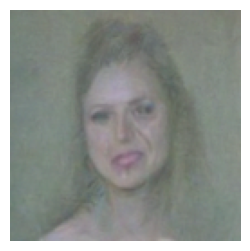

In [ ]:
noisy_stuff = torch.randn((1,3,128,128), device=device)
model.eval()
with torch.no_grad():
  # loop over time and progressively denoise your randn
  x = torch.linspace(0.0001, 0.01, t_max, device=device)
  alpha = 1 - x
  alphaBar = torch.cumprod(alpha, dim=0)
  for t in range(t_max-1, -1, -1):
      alphaT, alphaBarT, xT = alpha[t], alphaBar[t], x[t]
      coef = (1-alphaT) / torch.sqrt(1-alphaBarT)
      output = model(noisy_stuff, torch.full((1,), t, dtype=torch.long, device=device))
      mean = (noisy_stuff - coef*output) / torch.sqrt(alphaT)
      noisy_stuff = mean + torch.sqrt(xT) * torch.randn_like(noisy_stuff) if t else mean
  sample = torch.clamp((noisy_stuff + 1)/2, 0, 1).cpu()

  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(sample[0].numpy(), (1,2,0)))
  plt.axis("off")
  plt.show()